# Imports

In [2]:
from fastai.text import *
from fastai.imports import *
from fastai.structured import *
from fastai.column_data import *
from torch.nn import functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

/home/dg/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
import gc
import pdb

# Data processing

## Func

In [4]:
def scale_vars(df, mapper, scale_col_exc):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n]) and n not in scale_col_exc]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

In [5]:
def proc_df2(df, y_fld = None, skip_flds=None, do_scale=True, scale_col_exc = None, na_dict=None,
             preproc_fn=None, max_n_cat=10, subset=None, mapper=None):
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    if y_fld is not None: 
        y = df[y_fld].values
        df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper, scale_col_exc)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    if y_fld is not None: 
        res = [pd.get_dummies(df, dummy_na=True), y, na_dict]
    else:
        res = [pd.get_dummies(df, dummy_na=True), na_dict]
    if do_scale: res = res + [mapper]
    return res

## app train

In [6]:
df_train = pd.read_csv('data/application_train.csv')

In [7]:
sk_id = set(df_train.SK_ID_CURR.values)

In [8]:
sk2tg = { k:v for k,v in df_train[['SK_ID_CURR', 'TARGET']].values}

## cc train

In [113]:
cc_train = pd.read_csv('data/credit_card_balance.csv')

In [114]:
cc_train = cc_train[cc_train['SK_ID_CURR'].isin(sk_id)]

In [115]:
cc_train.drop(['SK_ID_PREV'], axis=1, inplace = True)

In [12]:
train_cats(cc_train)

In [13]:
cc_sk_id = set(cc_train['SK_ID_CURR'].values)

In [14]:
cc_y = [sk2tg[i] for i in cc_sk_id]

In [15]:
cc_sk_id = list(cc_sk_id)

In [16]:
x_train,x_valid, y_train, y_valid = train_test_split(cc_sk_id, cc_y, test_size=0.2, stratify = cc_y)

In [17]:
cc_train_proc, _, _ = proc_df2(cc_train, do_scale = True, scale_col_exc = ['SK_ID_CURR', 'MONTHS_BALANCE'])

In [18]:
def df_to_maxtrix(df, cols): return df[cols].values.astype(np.float32)

In [19]:
cc_train_proc = cc_train_proc.sort_values(by = ['SK_ID_CURR', 'MONTHS_BALANCE'])

In [120]:
cc_train = cc_train.sort_values(by = ['SK_ID_CURR', 'MONTHS_BALANCE'])

In [20]:
cols = [i for i in cc_train_proc.columns if i not in ['SK_ID_CURR','MONTHS_BALANCE']]
cc_train_group = cc_train_proc.groupby(['SK_ID_CURR']).apply(lambda x: df_to_maxtrix(x, cols))

In [309]:
cc_train.head(6)

,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1636141,100006,-6,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
655566,100006,-5,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1399895,100006,-4,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1347528,100006,-3,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
520387,100006,-2,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
584804,100006,-1,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0


# Data loader

## function

In [21]:
class SortishSamplerRNN(Sampler):
    def __init__(self, data_source, sk_id):
        self.data_source, self.sk_id = data_source, sk_id

    def __len__(self): return len(self.sk_id)

    def __iter__(self):        
        d={}
        for i in range(len(self.sk_id)): d.setdefault(len(self.data_source[self.sk_id[i]]), []).append(i)        
        result = [d[n] for n in sorted(d, reverse=True)]
        result = [i for j in result for i in j]
        return iter(result)

In [22]:
class ColumnarRNNDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, np.array(y, dtype=np.float32)

    def __len__(self): return len(self.y)

    def __getitem__(self, idx): return [self.x[idx], self.y[idx]]

In [24]:
class ColumnarRNNModelData(ModelData):
    @classmethod
    def from_data_frames(cls, path, trn_x, val_x, trn_y, val_y, 
                         tr_sampler = None, val_sampler = None, 
                         bs=64, shuffle=False):
        trn_ds  = ColumnarRNNDataset(trn_x, trn_y)
        val_ds  = ColumnarRNNDataset(val_x, val_y)
        return cls.get_dl(path, trn_ds, val_ds,
                          tr_sampler = tr_sampler, val_sampler = val_sampler, 
                          bs = bs, shuffle=shuffle)
    
    @classmethod
    def get_dl(cls, path, trn_ds, val_ds,
               tr_sampler = None, val_sampler = None, 
               bs = 64, shuffle=False):
        trn_dl = DataLoader(trn_ds, bs, shuffle=shuffle, sampler = tr_sampler, num_workers=1)
        val_dl = DataLoader(val_ds, bs, shuffle=shuffle, sampler = val_sampler, num_workers=1)
        return cls(path, trn_dl, val_dl)

## build

In [25]:
bs = 1024; PATH = ''

In [26]:
trn_samp = SortishSamplerRNN(cc_train_group, x_train)
val_samp = SortishSamplerRNN(cc_train_group, x_valid)

In [27]:
md  = ColumnarRNNModelData.from_data_frames(PATH,
                                            trn_x = x_train, val_x = x_valid, 
                                            trn_y = y_train, val_y = y_valid,
                                            tr_sampler = trn_samp, val_sampler = val_samp,
                                            bs=bs, shuffle=False)

# architechture

In [59]:
class linear_block(nn.Module):
    def __init__(self, ip_sz, op_sz, drop):
        super().__init__()
        self.op_sz = op_sz
        self.ln = nn.Linear(ip_sz, op_sz)
        kaiming_normal(self.ln.weight.data)
        if drop is not None:
            self.bn = nn.BatchNorm1d(op_sz)
            self.drp = nn.Dropout(drop)
        
    def forward(self, x): return self.drp(self.bn(F.relu(self.ln(x)))) if self.op_sz != 1 else self.ln(x)

In [60]:
class rnn_block(nn.Module):
    def __init__(self, input_size = 36, hidden_size = 64, num_layers = 2, wdrop = 0.2, dropouto = 0.4):
        super().__init__()        
        self.rnn = WeightDrop(nn.LSTM(input_size, hidden_size, num_layers, batch_first = True), wdrop)
        self.dropouto = LockedDropout(dropouto)
    
    def forward(self, cc_inp_pack):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            packed_output, _ = self.rnn(cc_inp_pack)        
        outp, _ = pad_packed_sequence(packed_output, batch_first=True)
        outp = self.dropouto(outp)
        return outp

In [61]:
class attention(nn.Module):
    def __init__(self, dim, ip_sz = 64, op_sz = 36, drop = 0.2):
        super().__init__()
        self.w = self.rand_p(ip_sz, op_sz)
        if dim == 1:
            self.v = self.rand_p(op_sz)  
        else:
            self.ln = linear_block(op_sz, op_sz, drop)
            self.v = self.rand_p(op_sz, op_sz)
           
    @staticmethod
    def rand_p(*sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))
    
    def forward(self, outp, mtrx = None):
        we = outp@self.w
        u = F.tanh(we)
        at = F.softmax(u@self.v, 1)
        xa = (at.unsqueeze(2)*outp).sum(1) if mtrx is None else self.ln((at*mtrx).sum(1))
        return xa, at

In [62]:
class RNNModel(nn.Module):
    def __init__(self, bs, cc_ref, cc_sk_id,  
                 hd_sz, dropouti, wdrop, dropouto, 
                 att_ip_drop, concat_drop,
                 ln_lyrs, ln_drop, ):        
        super().__init__()
        self.bs, self.cc_sk_id, self.cc_ref, self.hd_sz = bs, cc_sk_id, cc_ref, hd_sz
        
        self.dropouti = LockedDropout(dropouti)
        self.rnn = rnn_block(hidden_size = hd_sz, wdrop = wdrop, dropouto = dropouto)      

        self.att_RNN = attention(dim = 1, ip_sz = self.hd_sz, op_sz = self.hd_sz)
        self.att_ip = attention(dim = 2, ip_sz = self.hd_sz, drop = att_ip_drop)
        
        self.concat_lyrs = linear_block(self.hd_sz*4+36, ln_lyrs[0], concat_drop)        
        self.lns = nn.ModuleList([linear_block(ln_lyrs[i], ln_lyrs[i+1], ln_drop[i]) for i in range(len(ln_lyrs)-1)])
    
    def pad_from_inp(self, inp):
        inp = [V(self.cc_ref[i]) for i in to_np(inp)]
        lengths = [i.size()[0] for i in inp]
        max_len = int(np.max(lengths))
        pad_inp = torch.stack([nn.ConstantPad2d((0,0,0,max_len-i.size()[0]), 0)(i) for i in inp])
        pad_inp_droped = self.dropouti(pad_inp)
        return pack_padded_sequence(pad_inp_droped, lengths, batch_first=True), pad_inp
    
    def pool(self, x, bs, is_max):
        '''pooling layer, stole from fastai'''
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(0,2,1), (1,)).view(bs,-1)
    
    def forward(self, x_in):
        #pdb.set_trace()
        cc_inp, pad_inp = self.pad_from_inp(x_in)
        
        outp = self.rnn(cc_inp)
        
        att_rnn_out, at_rnn_m = self.att_RNN(outp)
        att_inp_out, at_inp_out_m = self.att_ip(outp, pad_inp)
        
        avgpool, mxpool = self.pool(outp, len(x_in), False), self.pool(outp, len(x_in), True)
        x = self.concat_lyrs(torch.cat([outp[:,-1,:], avgpool, mxpool, att_rnn_out, att_inp_out], 1))
        for lyer in self.lns: x = lyer(x)
        
        return x.view(-1), at_rnn_m, at_inp_out_m

# Learner

## Build

In [63]:
def bcewl(ip,tg): return F.binary_cross_entropy_with_logits(ip, tg, tg*0.6+0.2, size_average=False)

In [64]:
[dropouti, wdrop, dropouto] = np.array([0.25, 0.2, 0.15])*0.5

In [65]:
m = RNNModel(bs = bs, cc_ref = cc_train_group, cc_sk_id = cc_sk_id,
             hd_sz = 128, dropouti = dropouti, wdrop = wdrop, dropouto = dropouto,
             att_ip_drop = 0.1, concat_drop = 0.1, 
             ln_lyrs = [600, 400, 200, 100, 1], ln_drop = [0.1, 0.1, 0.1, 0.1])

In [66]:
RNN_learner = Learner.from_model_data(m, md)

In [67]:
RNN_learner.crit = bcewl

## learning rate

In [54]:
RNN_learner.lr_find()

 57%|█████▋    | 39/68 [00:12<00:09,  3.08it/s, loss=384]

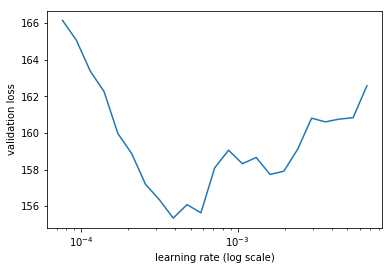

In [55]:
RNN_learner.sched.plot()

## fit

In [68]:
lr = 1e-4

In [155]:
RNN_learner.fit(lr, n_cycle = 3, cycle_len = 1)

epoch      trn_loss   val_loss                             
    0      143.26762  145.529378
    1      143.522918 145.716162                           
    2      143.170848 145.176775                           


[array([145.17678])]

In [78]:
RNN_learner.save('RNN_learner')

# plot

In [80]:
it = iter(md.trn_dl)

In [160]:
x, y = next(it)

In [161]:
y_pred, a1, a2 = RNN_learner.predict_array(to_np(x))

In [162]:
df_pss = [i for i,j in enumerate(y) if j==1]

In [174]:
pos = 2
df_ps = df_pss[pos]

In [186]:
def plot_bar(df_ps, a1):
    a1 = to_np(a1)[df_ps]
    time_range = list(range(-len(a1)-1, -1))
    plt.figure(figsize=(20,10))
    plt.bar(time_range, a1)

In [189]:
def plot_heatmap(df_ps, a2):
    plt.gcf().clear()
    fig, ax = plt.subplots(figsize=(100,50))
    a2 = to_np(a2)[df_ps].T
    time_range = list(range(-len(a2.T)-1, -1))
    ax = sns.heatmap(a2, xticklabels = time_range, yticklabels=cols, cmap="YlGnBu")
    plt.show()

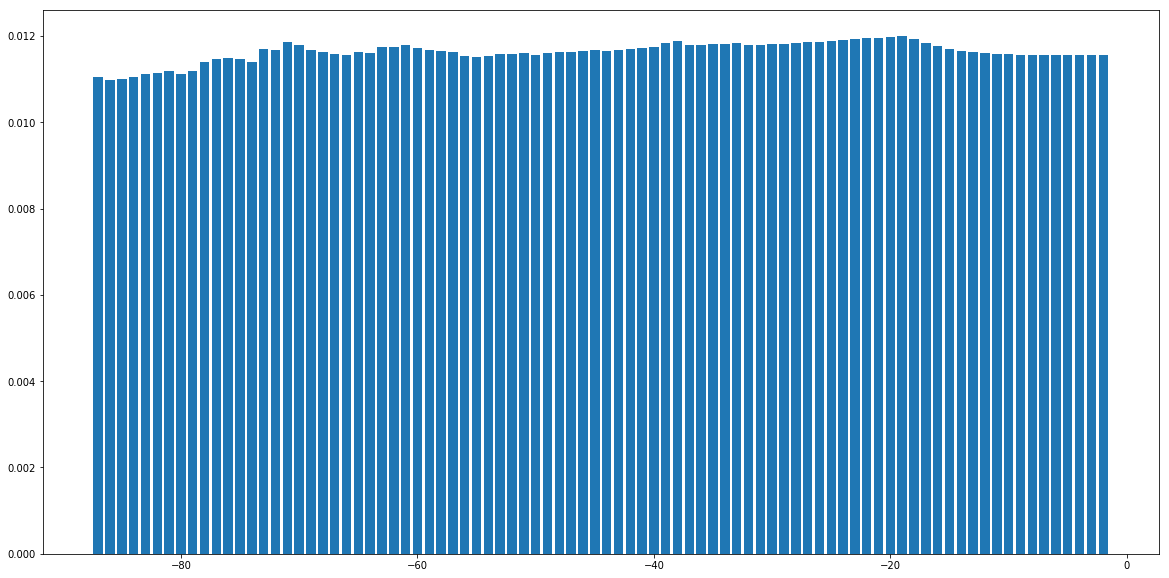

In [187]:
plot_bar(df_ps, a1)

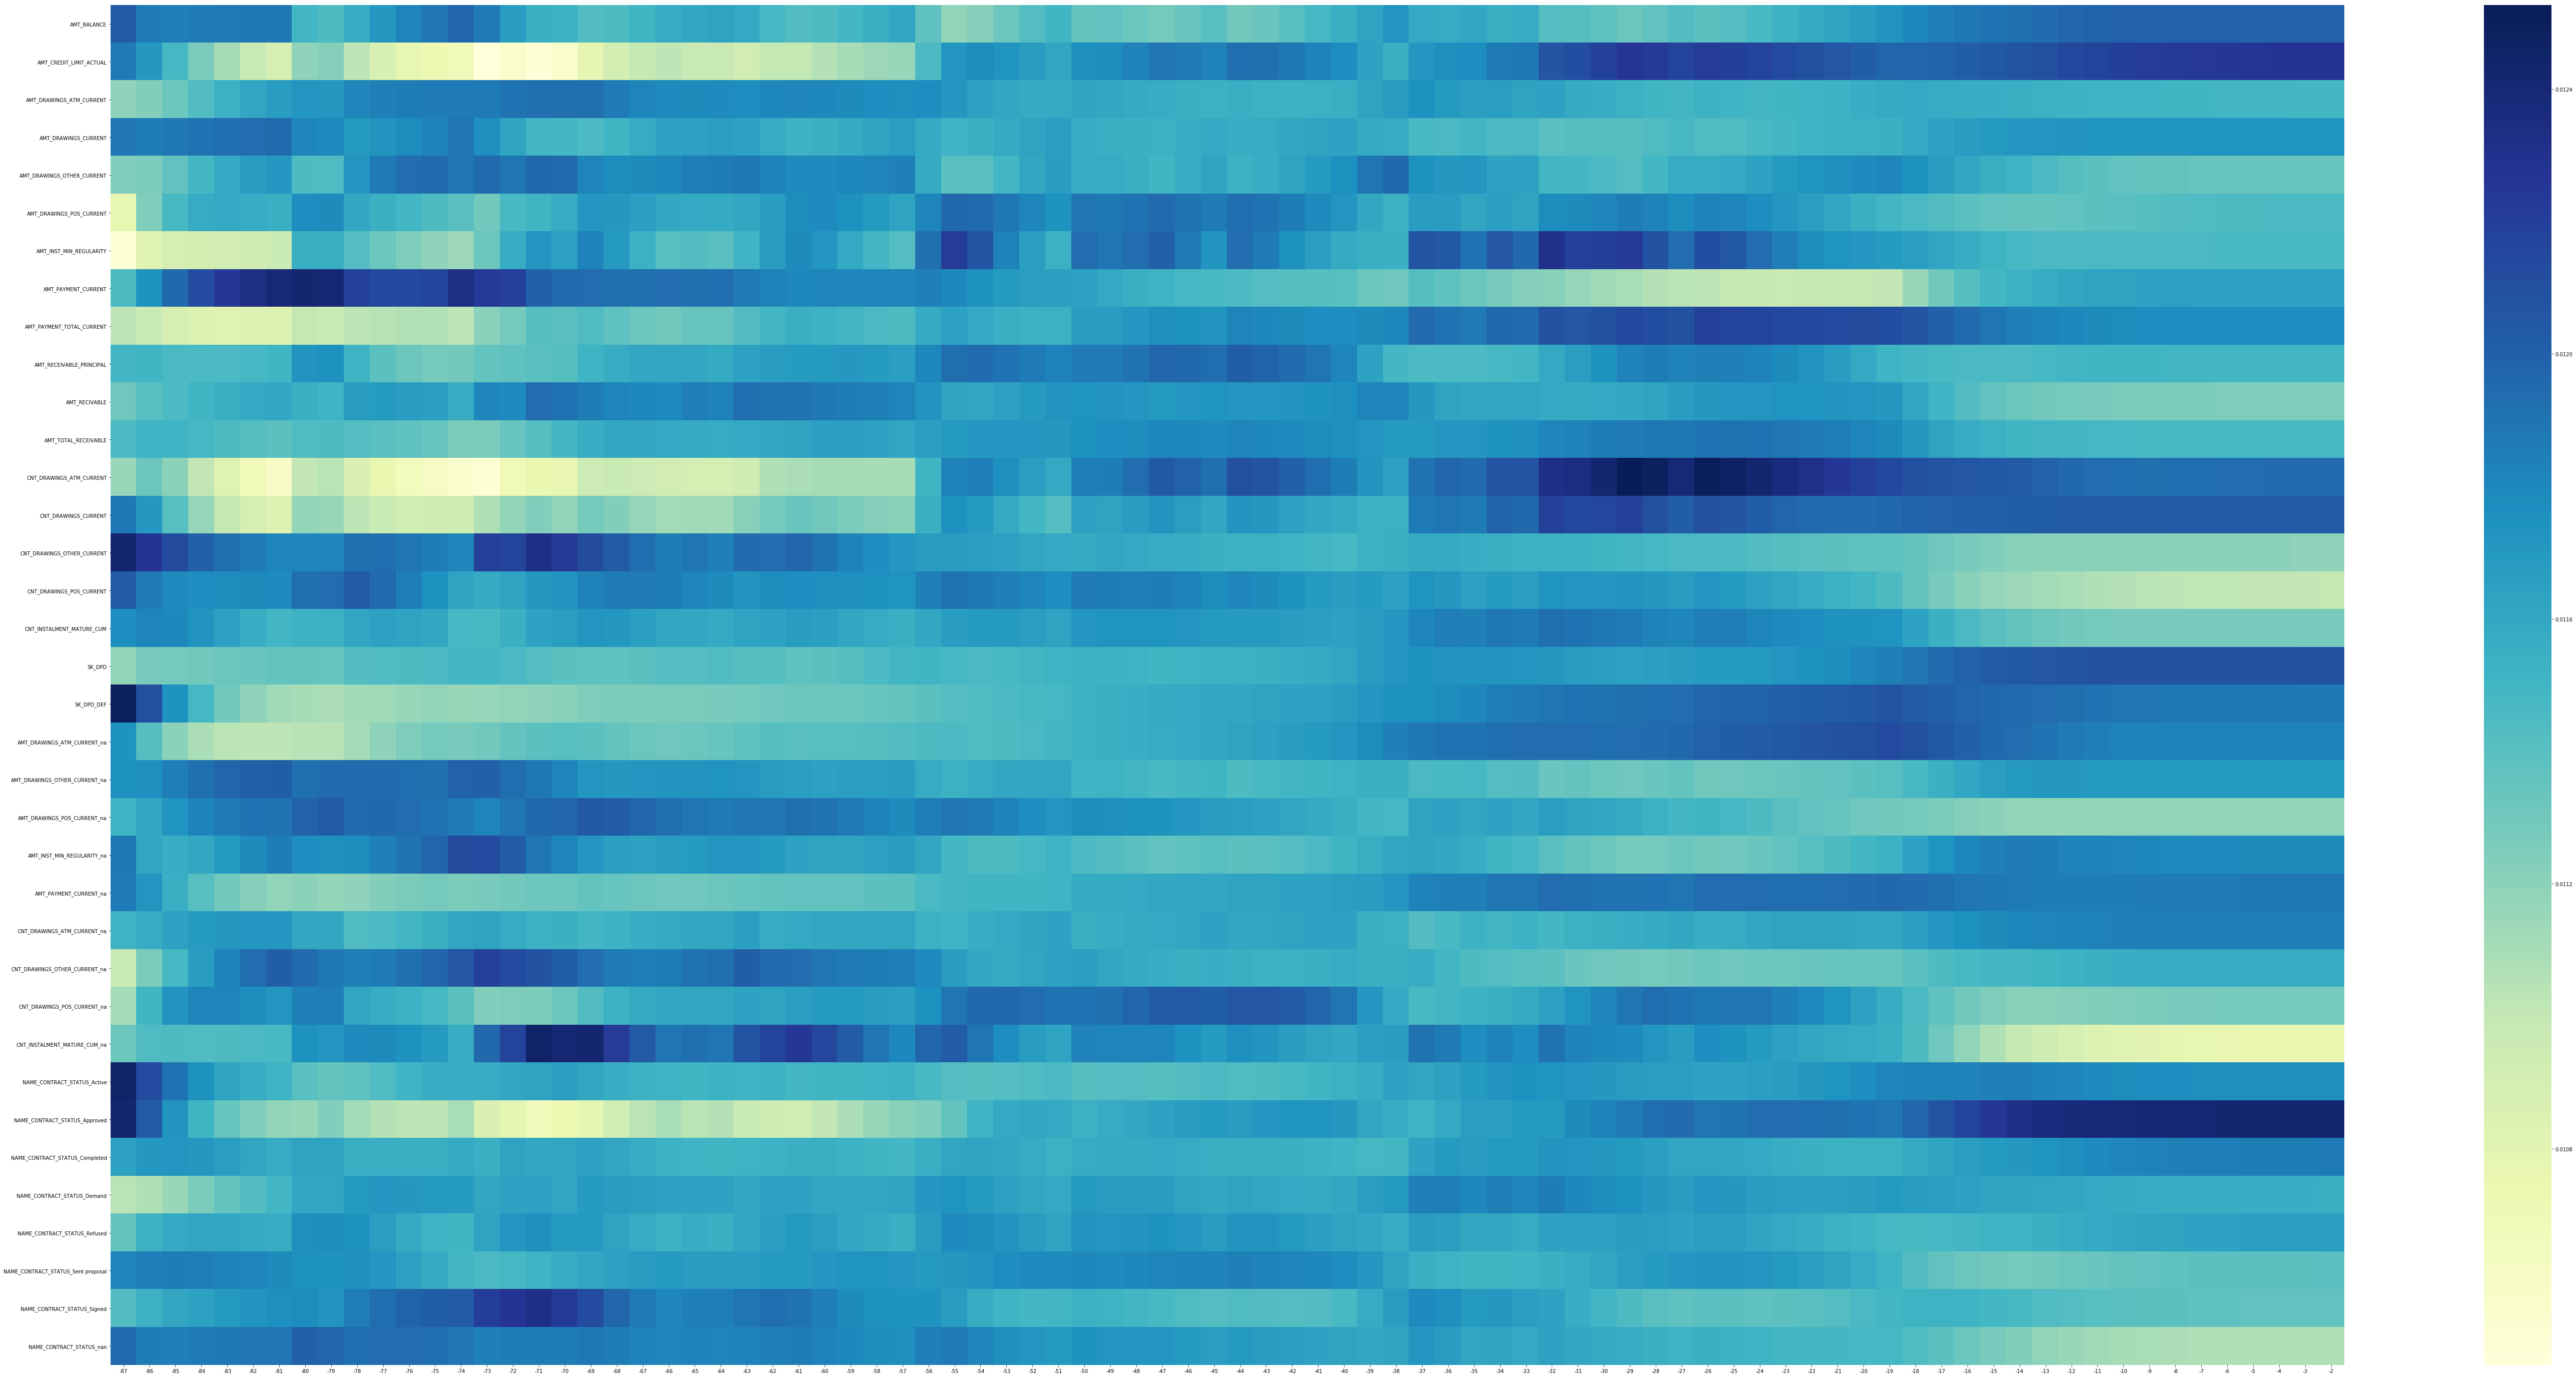

In [190]:
plot_heatmap(df_ps, a2)

In [194]:
def plot_line(df_ps, col):
    cc_train[cc_train['SK_ID_CURR'] == x[df_ps]][['MONTHS_BALANCE', col]].plot.line('MONTHS_BALANCE', col)

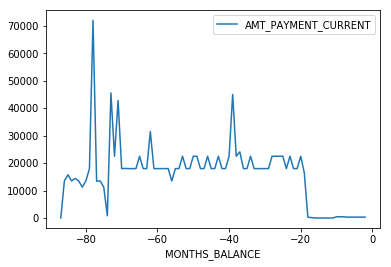

In [196]:
plot_line(df_ps, 'AMT_PAYMENT_CURRENT')

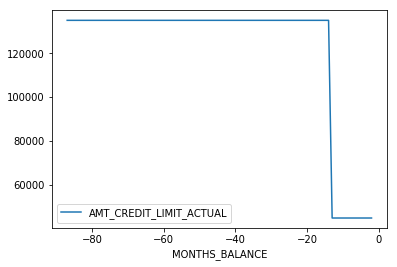

In [195]:
plot_line(df_ps, 'AMT_CREDIT_LIMIT_ACTUAL')

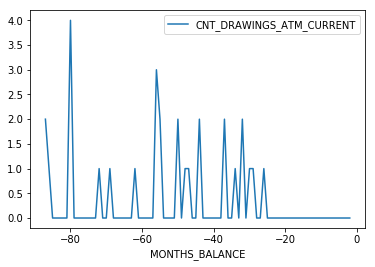

In [197]:
plot_line(df_ps, 'CNT_DRAWINGS_ATM_CURRENT')

In [206]:
pos = 60
df_ps = df_pss[pos]

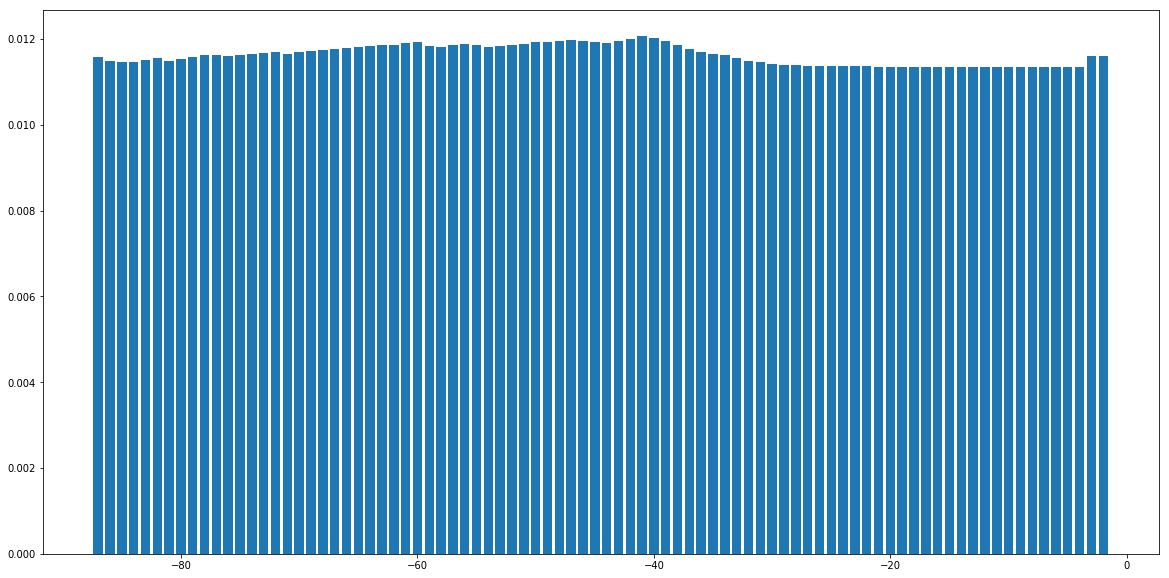

In [207]:
plot_bar(df_ps, a1)

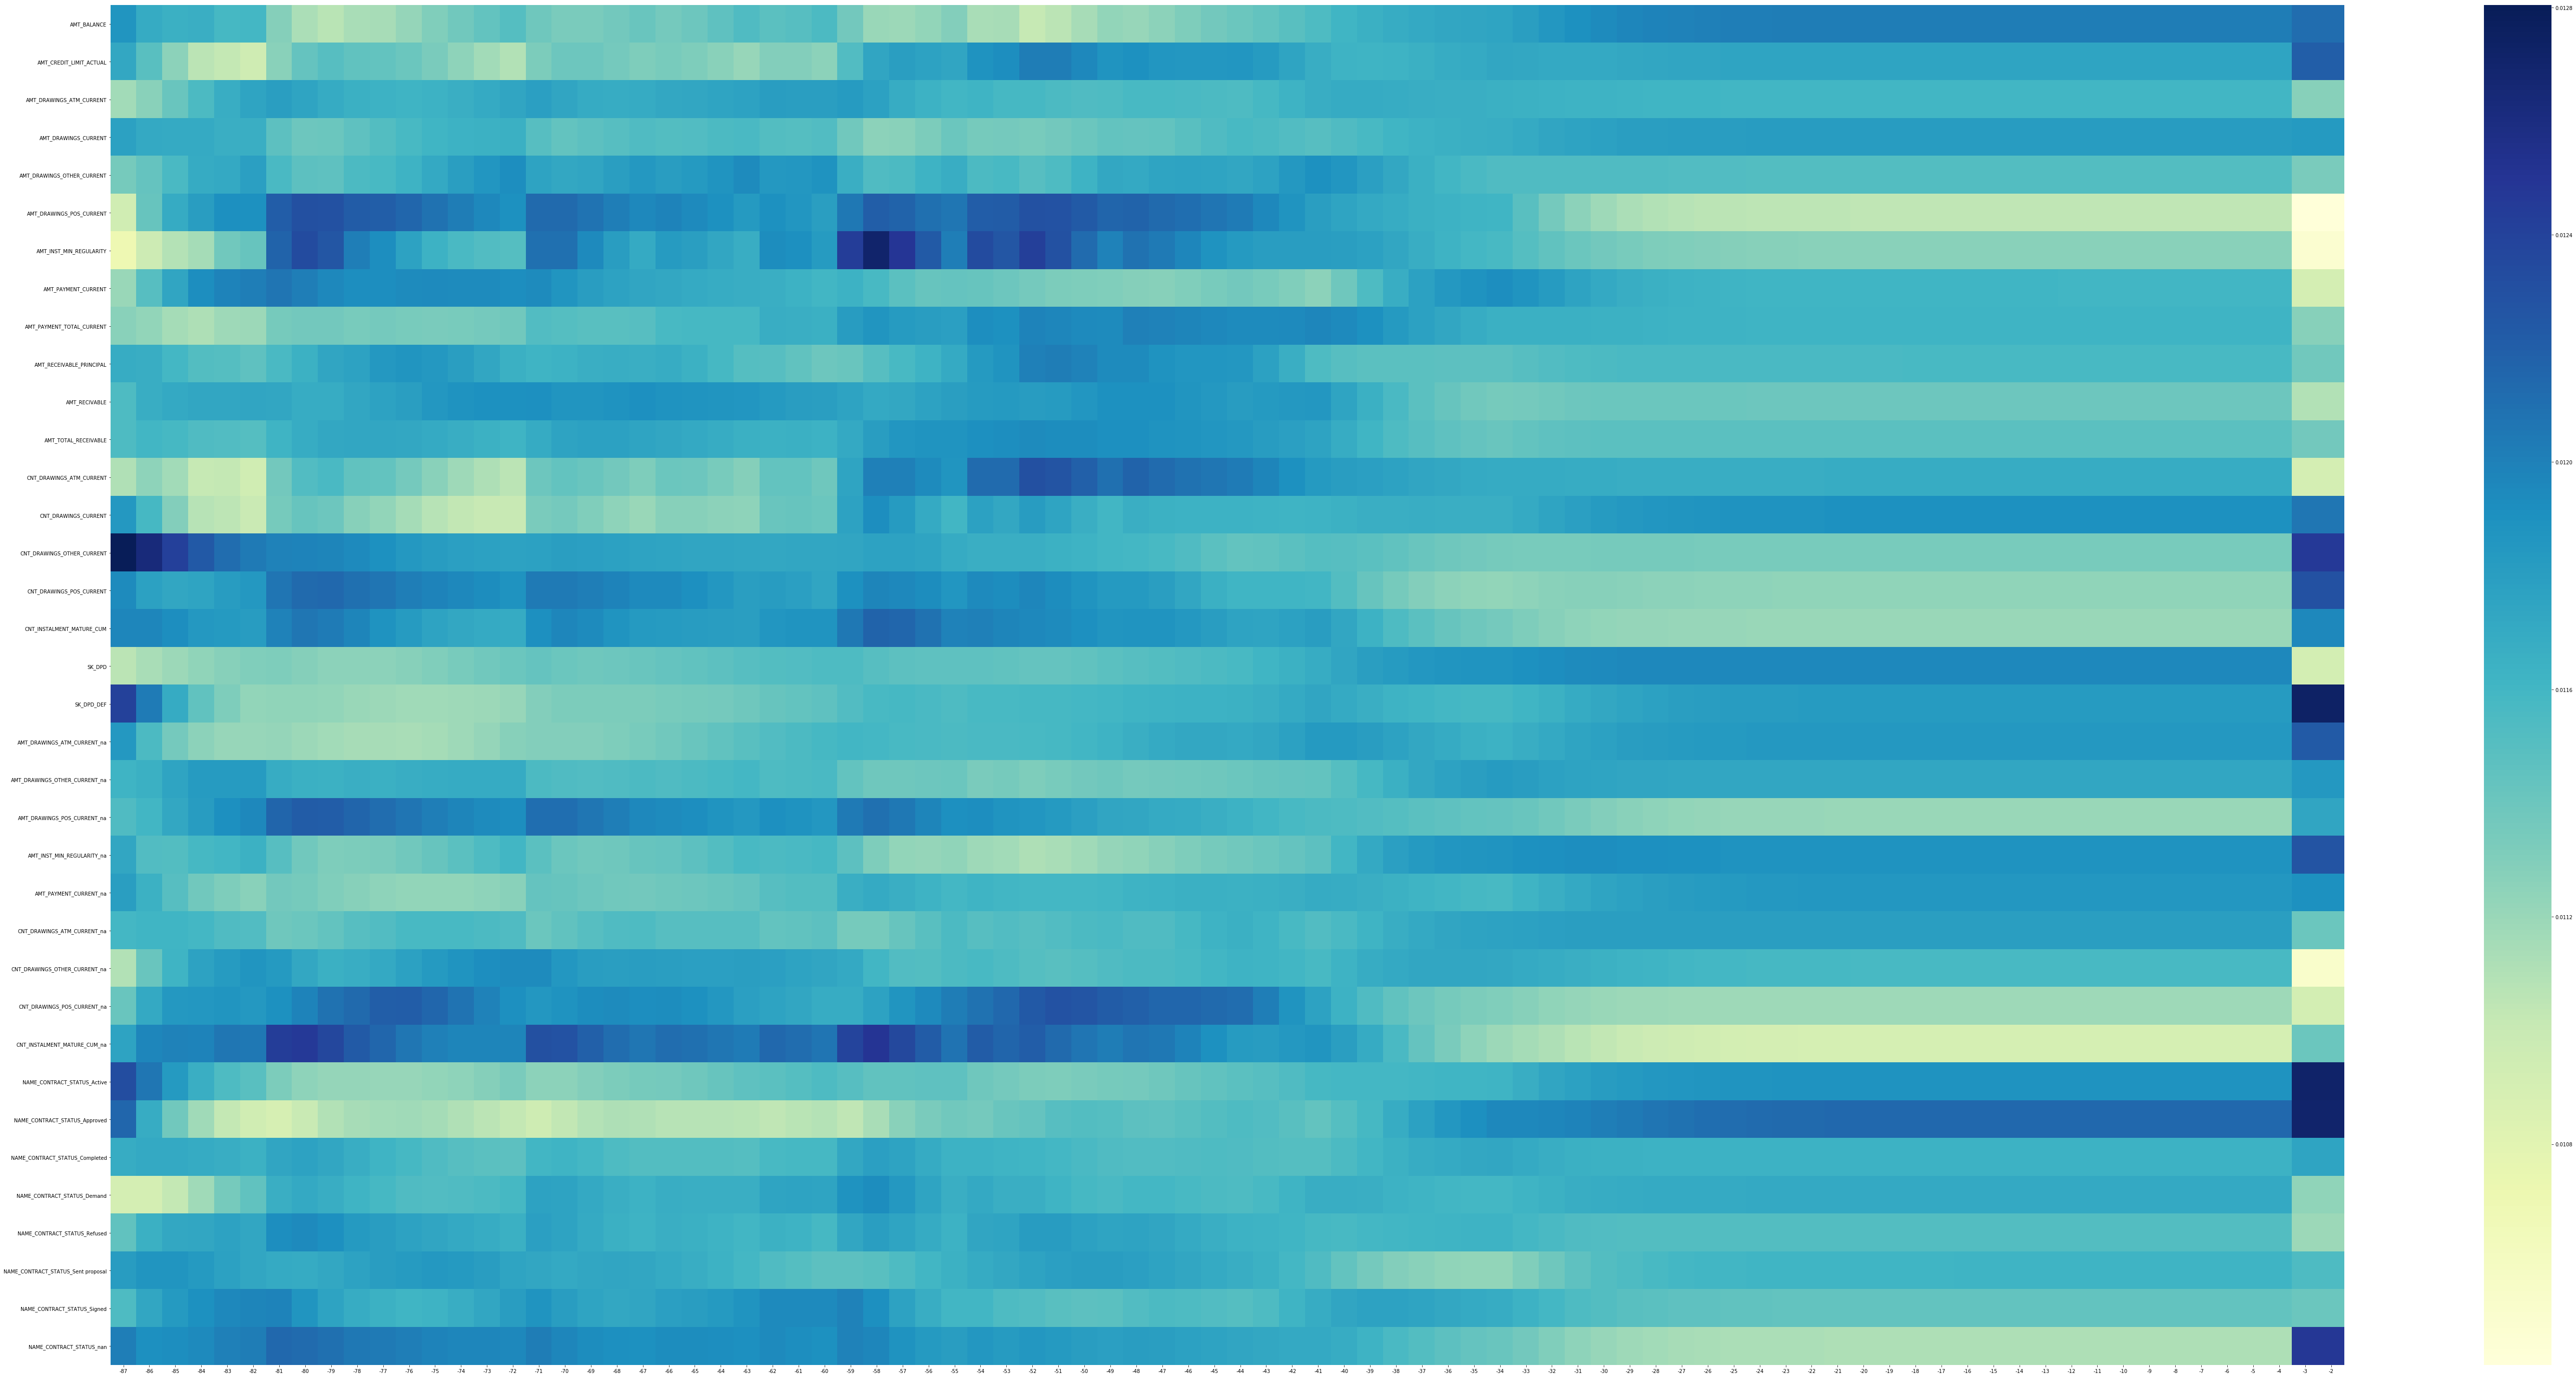

In [208]:
plot_heatmap(df_ps, a2)

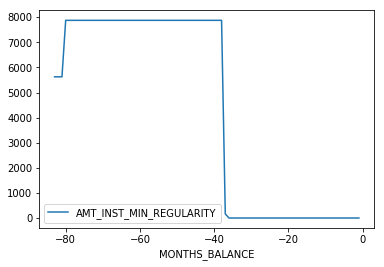

In [209]:
plot_line(df_ps, 'AMT_INST_MIN_REGULARITY')

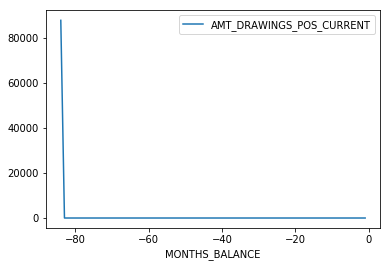

In [211]:
plot_line(df_ps, 'AMT_DRAWINGS_POS_CURRENT')

In [271]:
x, y = next(it)

In [272]:
y_pred, a1, a2 = RNN_learner.predict_array(to_np(x))

In [273]:
df_pss = [i for i,j in enumerate(y) if j==1]

In [300]:
pos = 30
df_ps = df_pss[pos]

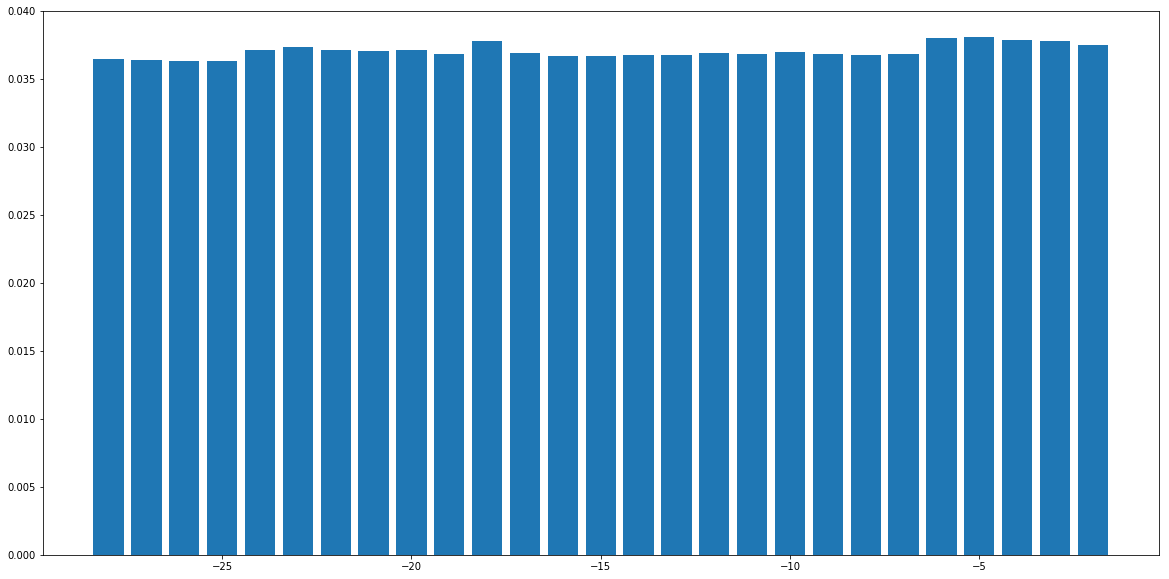

In [301]:
plot_bar(df_ps, a1)

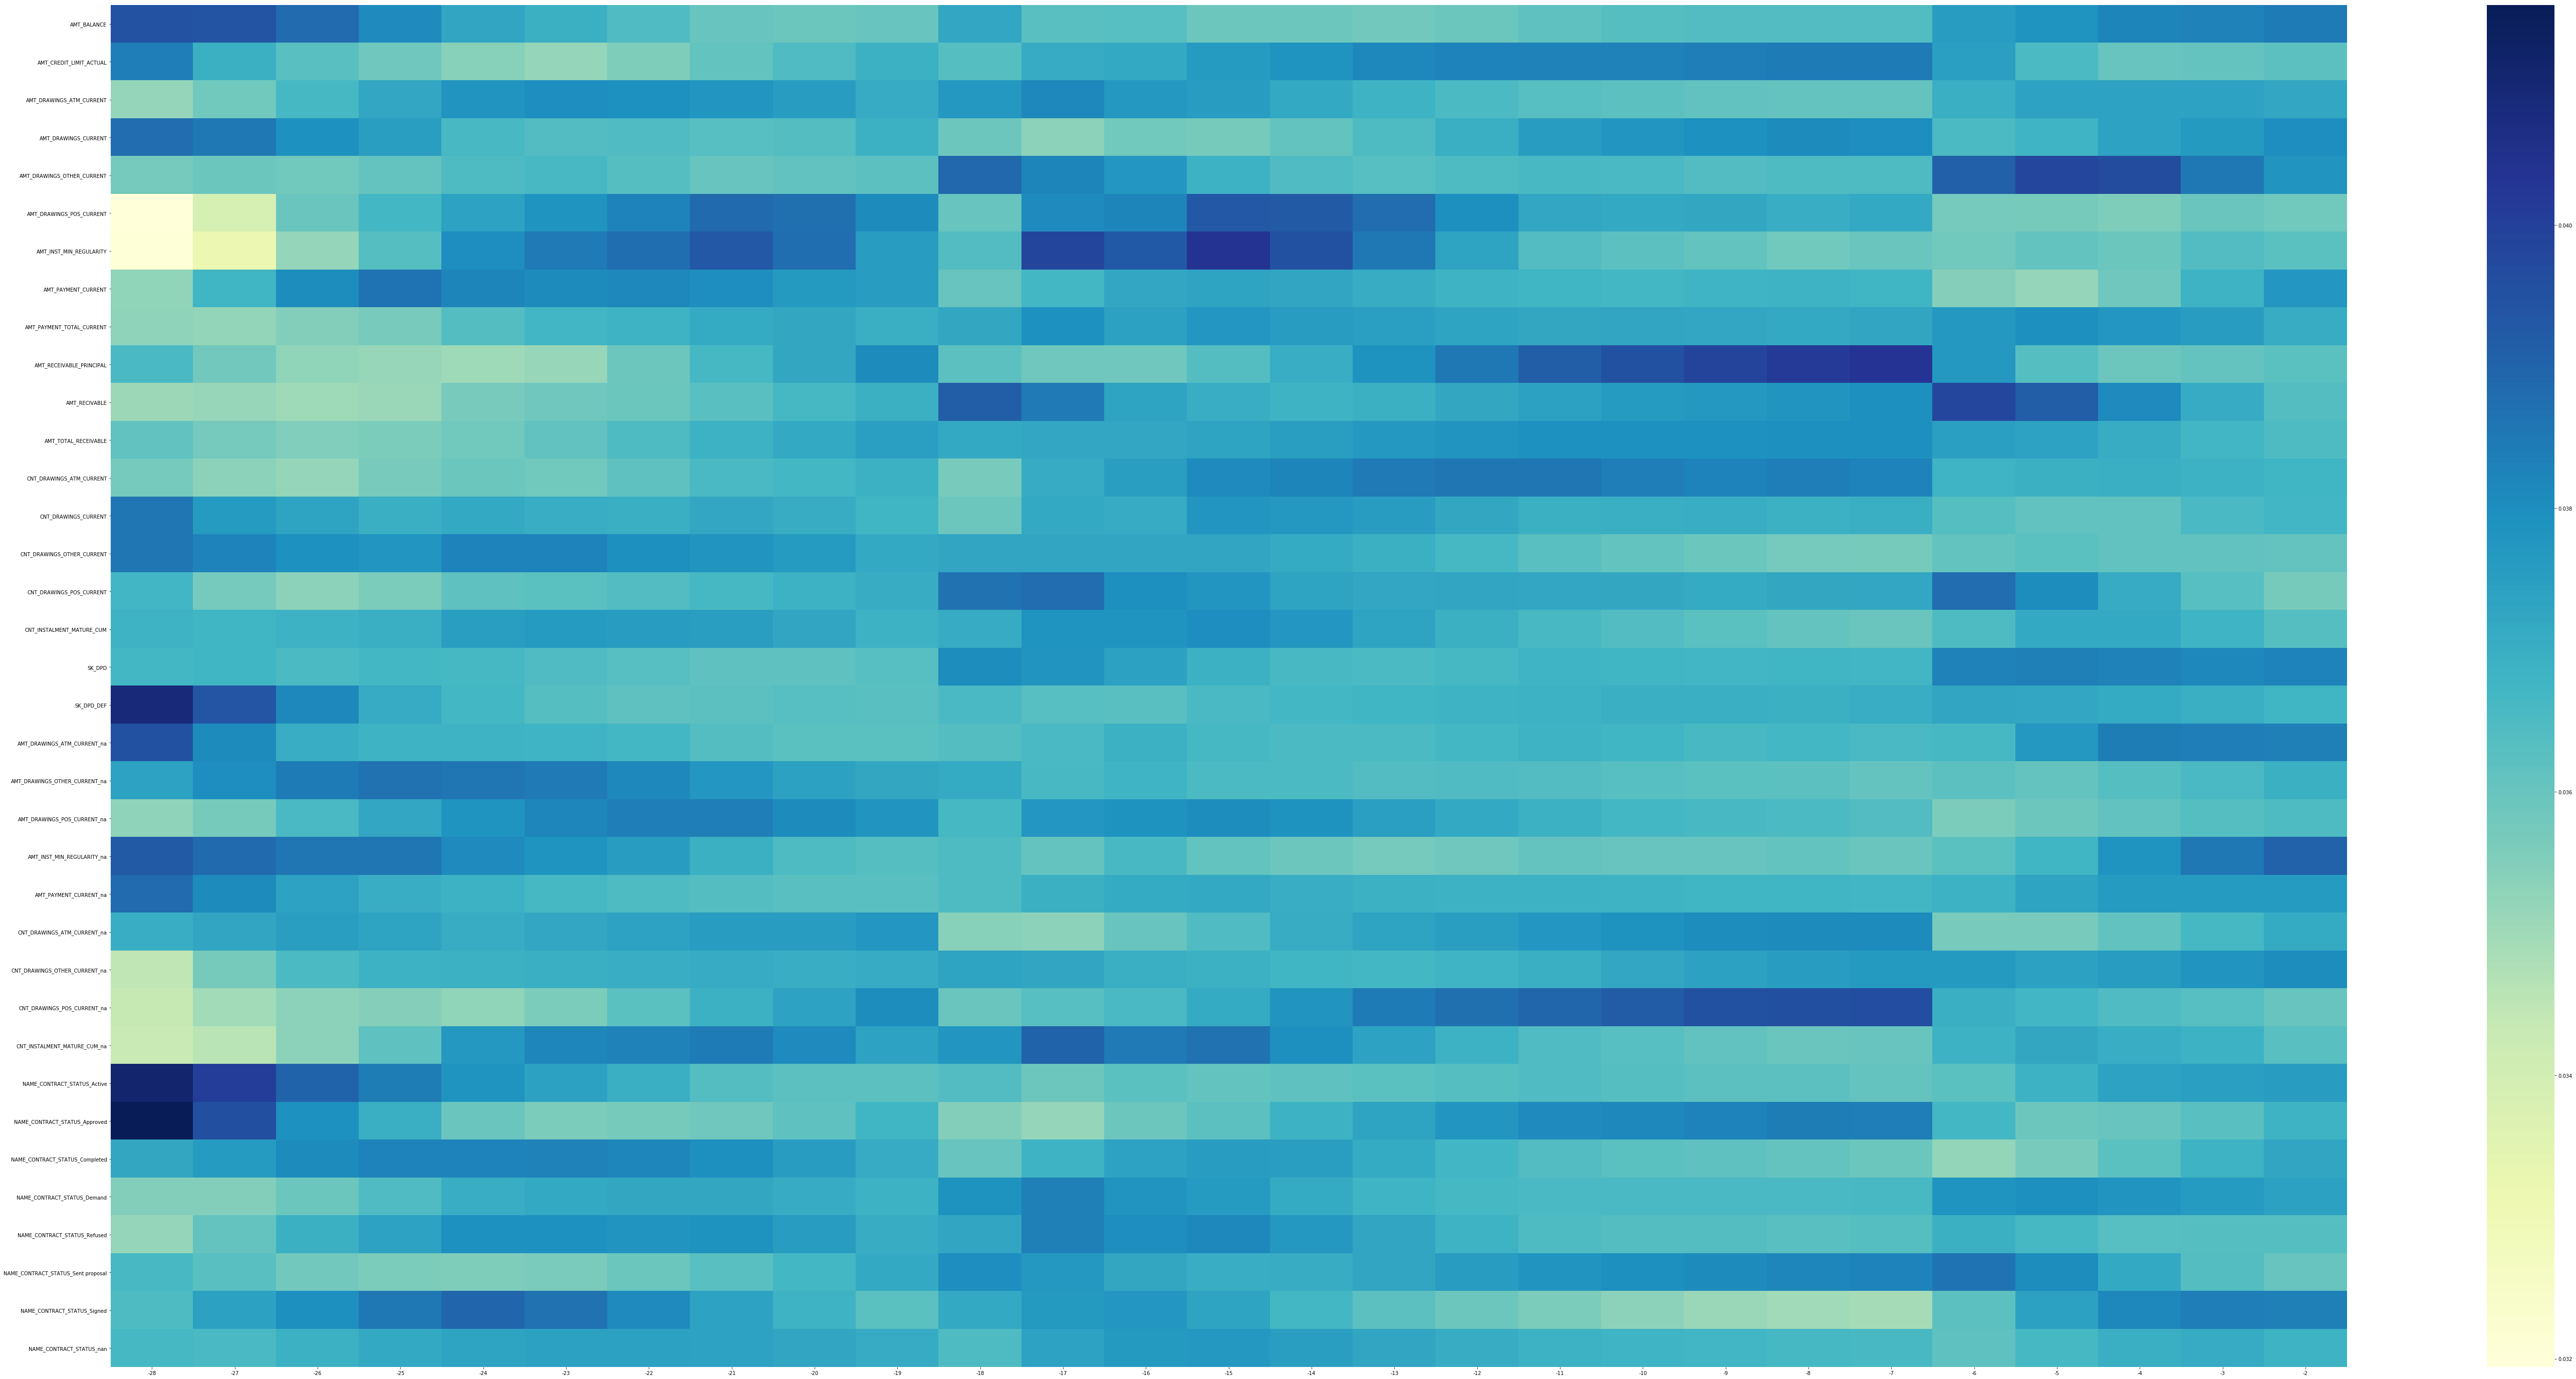

In [302]:
plot_heatmap(df_ps, a2)

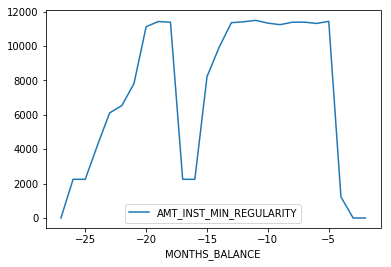

In [303]:
plot_line(df_ps, 'AMT_INST_MIN_REGULARITY')

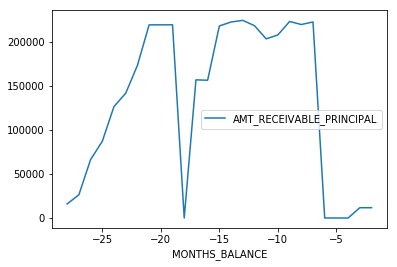

In [304]:
plot_line(df_ps, 'AMT_RECEIVABLE_PRINCIPAL')

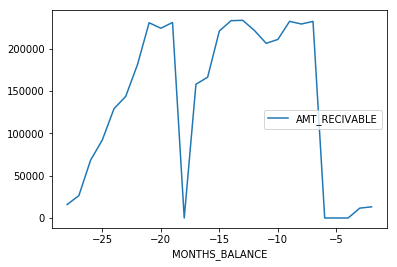

In [306]:
plot_line(df_ps, 'AMT_RECIVABLE')